In [25]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import operator as op
from decimal import *
import pickle
# import mpld3
# mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [4]:
%run ../cow.py

In [7]:
# 21 from Hamming Code
# Quantize by 21 (to get all possible RS blocklengths)
# 1400 = min bits for one phase, 4200 = entire protocol
# hs_rs_table(op_SNR, rate, blocklength)
class node_table():
    op_SNR = arange(-2.5, 11, 0.01)
#     padd = 0.1*10**(-9)
    
    # num_nodes = n
    def __init__(self, n, down=True):
        self.num_node = n
        minb = n * 160 * 7 / 4
#         quantize = (20000-minb*2)/100
        bitrange = arange(minb, 3*1400-minb, 21)
        self.bitrange = bitrange
#         rate = num_node * 160 / bitrange * 7 / 4
#         blocklength = bitrange / 21
        num_tables = len(bitrange)
#         print('num tables', num_tables)
#         print('the blocklength range', floor(bitrange/21))
        self.tables = {}
        for b in self.bitrange:
#             b = int(bitrange[bidx])
            block = b/21 if down else b/21/n
            self.tables[b] = hs_rs_table(self.op_SNR, n*160/b, int(block))
#             codetable = self.tables[b]
#             actualSNR = codetable[0][np.where(np.array(codetable[1])<=self.padd)[0][0]]
#             print(b, actualSNR)

In [76]:
# Final

# p_add_1 = 0.1 * 10**(-9)
# p_add_2 = 0.1 * 10**(-9)
# p_add_3 = 0.1 * 10**(-9)

# SNR_down = downtable[0][np.where(np.array(downtable[1])<=p_add_1)[0][0]]
# SNR_up = uptable[0][np.where(np.array(uptable[1])<=p_add_2)[0][0]]
# xorfunc = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

def xor_analysis_opt(N, p_add_3, nom_SNR, actual_SNR, p_add_1=10**(-9), p_add_2=10**(-9)):
    hcrit_1 = hcrit_2 = 10**((actual_SNR - nom_SNR)/10) # linear fade
    p_fade_1 = 1 - np.exp(-hcrit_1)
#     hcrit_2 = 10**((actual_SNR - nom_SNR)/10) # linear fade
    p_fade_2 = 1 - np.exp(-hcrit_2)
#     p_fade_1 = p_fade_2 = 1 - np.exp(-1)
    p_link_1 = p_fade_1 + (1 - p_fade_1) * p_add_1
    p_link_2 = p_fade_2 + (1 - p_fade_2) * p_add_2
    q = p_add_1 / p_link_1
#     p_add_3 = xorfunc(SNR)
    
    result = 0
    for ad in range(1, N+1):
        p_ad = nCr(N, ad) * (1 - p_link_1)**ad * p_link_1**(N-ad)
        adn_result = 0
        for adu in range(1, ad+1):
            p_adu = nCr(ad, adu) * (1 - p_add_2)**adu * p_add_2**(ad-adu)
            p_adn_success = (1 - p_add_3)**(ad - adu)
            adn_result += p_adu * p_adn_success
            
        b_result = 0
        for b in range(0, N-ad+1):
            bu_result = 0
            for bu in range(0, b+1):
                p_bu = nCr(b, bu) * (1 - p_add_2)**bu * p_add_2**(b-bu)
                p_bu_success = (1 - p_add_3)**bu
                p_rest_success = ((1 - p_link_2**ad) * (1 - p_add_3)**2)**(N-ad-bu)
                bu_result += p_bu * p_bu_success * p_rest_success
                
            p_b = nCr(N-ad, b) * q**b * (1-q)**(N-ad-b)
            b_result += p_b*bu_result
            
        result += p_ad * adn_result * b_result
#         print 'P(success)', result, 'P(b)', b_result, 'P(adn)', adn_result 
#     print p_add_3, result, b_result
    return result

Optimized:

Hyperparameter: Downlink Target Drop Probability, Uplink Target Drop Probability  
Big Search: Effective SNR  
Set Effective SNR (SNR experienced at the receiver after the fade):  
*  What is the downlink blocklength such that we achieve Downlink Target Drop at this Effective SNR? --> Down blocklength (lookup in table << only additive noise)  
*   What is the downlink blocklength such that we achieve Downlink Target Drop at this Effective SNR? --> Up blocklength  
*   XOR blocklength --> 4,200 - Down blocklength - Up blocklength
*   Calculate Code Drop Probability for XOR blocklength at Effective SNR --> Additive noise in XOR phase
*   Search Range(Effective SNR, Effective SNR + 90 dB) << this represents SNR at Transmitter
* *       Do calculate of XOR Analysis with XOR_Additive Noise, Fade = f(Effective_SNR - Transmitter_SNR)
Return Transmitter_SNR + other data for funs so Leah can analyse it

2 approximations:
* Loudest Talker
* If fade too large code can't save --> Total Probability Rule
* If fade not too large, it's AT the critical fade (this is worse than reality, it's a worst case scenario)

Max Optimized -- Optimized over alpha (downlink target drop), beta (uplink target drop), rates (downlink blocklength, uplink blocklength) (guarantees XOR <= some target e.g. $10^{-9}$)

Medium Optimized -- Optimized over alpha, beta, **not** optimized over rates (downlink = 1400, uplink = 1400 = total/3) (same guarantee, XOR <= target)

Not Optimized -- Given alpha/beta, given rates, find SNR st XOR <= target
At $10^{-3}$ Not Optimized should return 11 (max of SNR_range) across the board because infeasible
        


In [42]:
# 1,400 * 3 phases = 4,200
def optimization(N, SNR_range, filepath_down, filepath_up, downtarget=10**(-9), uptarget=10**(-9)):
    #downtarget, uptarget = logsearch(10**(-8), 10**(-10), 20)
    protocol_target = 10**(-9)
#     downtarget, uptarget = 1 * 10**(-9), 1 * 10**(-9)
    downFile = filepath_down + str(N) + '.in'
    downNode = load_table(downFile)
    upFile = filepath_up + str(N) + '.in'
    upNode = load_table(upFile)
    for actual_SNR in SNR_range:
        downbit, upbit = float("inf"), float("inf")
        for bit in downNode.bitrange:
            bittable = downNode.tables[bit]
            func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
            if func(actual_SNR) <= downtarget:
                downbit = bit
                break
        for bit in upNode.bitrange:
            bittable = upNode.tables[bit]
            func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
            if func(actual_SNR) <= uptarget:
                upbit = bit
                break
        # Replace magic number below
        xorbit = max(0, 4200 - downbit - upbit)
#         if math.isnan(downbit) or math.isnan(upbit) or math.isnan(xorbit):
#             print downbit, upbit, xorbit
#         if xorbit > 20000: return (float("inf"), float("inf"), downbit, upbit, xorbit)
        # We calculate reeddrop each time because the rate changes every time (new table)
        blocklength = int(xorbit / 21)
        rate = N * 160 / xorbit * 7 / 4 if xorbit else float("inf")
        if rate > 1: continue
        k = (1-rate)*blocklength
        pbitdrop = Q(np.sqrt(2*10**(actual_SNR/10)))
        hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
        hcf = 1 - (1-hcerr)**3
        reeddrop = sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)])
        for nom_SNR in arange(actual_SNR, actual_SNR+90, 0.1):
            xor_opt = xor_analysis_opt(N, reeddrop, nom_SNR, actual_SNR, downtarget, uptarget)
            if 1-xor_opt <= protocol_target:
                return (actual_SNR, nom_SNR, downbit, upbit, xorbit)

In [43]:
filepath_down = '../data_tables/short_block_test/down/n'
filepath_up = '../data_tables/short_block_test/up/n'

## Results from optimizing

In [44]:
%%time
SNR_range = arange(-2.5, 11, 0.01)
data = zeros((5, 5))
for n in range(1, 6):
    z = optimization(n, SNR_range, filepath_down, filepath_up, 10**(-9), 10**(-9))
    data[n-1] = z

# print data

CPU times: user 1min 3s, sys: 498 ms, total: 1min 4s
Wall time: 1min 6s


In [8]:
print data

[[     nan      nan      nan      nan      nan]
 [    2.14    90.74  1463.    2030.     707.  ]
 [    3.55    71.95  1302.    1890.    1008.  ]
 [    5.65    73.55  1351.    1645.    1204.  ]
 [   10.79    32.59  1400.    1400.    1400.  ]]


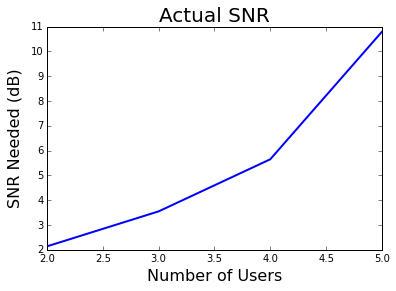

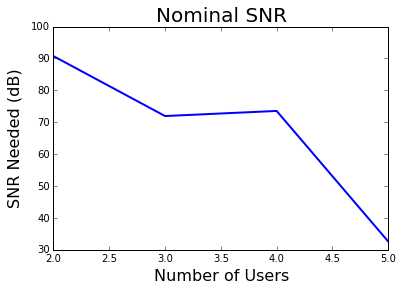

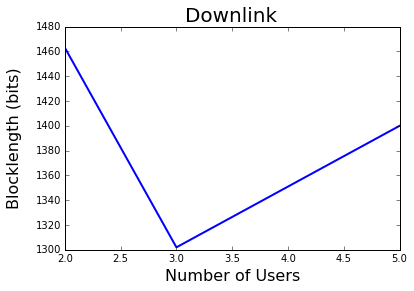

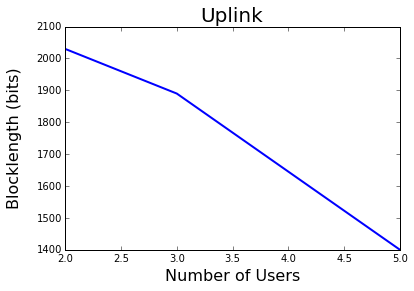

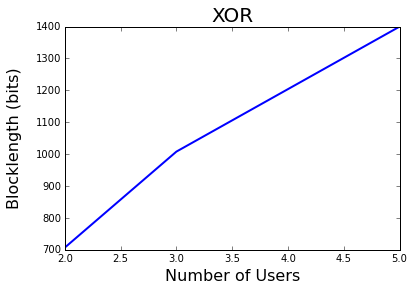

In [9]:
plot(range(2, 6), data[1:5, 0], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Actual SNR', fontsize=20)

figure()
plot(range(2, 6), data[1:5, 1], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR', fontsize=20)

figure()
plot(range(2, 6), data[1:5, 2], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Downlink', fontsize=20)

figure()
plot(range(2, 6), data[1:5, 3], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Uplink', fontsize=20)

figure()
plot(range(2, 6), data[1:5, 4], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('XOR', fontsize=20)

## Results from not optimizing
Not worth it, just remake bit=1400 tables  
Ignore the below

Using the optimization tables but simulating a not optimized protocol.  
Total Blocklength = 4,200 bits  
Each phase should = 1,400 bits  

| Number of Nodes | Downlink Number of Bits |
|:---------------:|:-----------------------:|
|        2        |        1400             |
|        3        |                         |
|        4        |                         |
|        5        |         1400            |

In [45]:
# 1,400 * 3 phases = 4,200
def not_optimized(N, SNR_range, filepath_down, filepath_up, downtarget=10**(-9), uptarget=10**(-9)):
    #downtarget, uptarget = logsearch(10**(-8), 10**(-10), 20)
    protocol_target = 10**(-9)
#     downtarget, uptarget = 1 * 10**(-9), 1 * 10**(-9)
    
    downTable = hs_rs_table(SNR_range, N*160/1400, int(1400/21))
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    upTable = hs_rs_table(SNR_range, N*160/1400, int(1400/21/N))
    upfunc = interp1d(upTable[0], upTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    for actual_SNR in SNR_range:
        downbit, upbit = 1400, 1400
        if downfunc(actual_SNR) > downtarget: continue
        if upfunc(actual_SNR) > uptarget: continue
        # Replace magic number below
        xorbit = 1400
        blocklength = int(xorbit / 21)
        rate = N * 160 / xorbit * 7 / 4 if xorbit else float("inf")
        if rate > 1: continue
        k = (1-rate)*blocklength
        pbitdrop = Q(np.sqrt(2*10**(actual_SNR/10)))
        hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
        hcf = 1 - (1-hcerr)**3
        reeddrop = sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)])
        for nom_SNR in arange(actual_SNR, actual_SNR+90, 0.1):
            xor_opt = xor_analysis_opt(N, reeddrop, nom_SNR, actual_SNR, downfunc(actual_SNR), upfunc(actual_SNR))
            if 1-xor_opt <= protocol_target:
                return (actual_SNR, nom_SNR, downbit, upbit, xorbit)

In [46]:
%%time
SNR_range = arange(-2.5, 11, 0.01)
not_opt_data = zeros((5, 5))
for n in range(1, 6):
    z = not_optimized(n, SNR_range, filepath_down, filepath_up, 10**(-7), 10**(-7))
    not_opt_data[n-1] = z

# print data

CPU times: user 48.6 s, sys: 214 ms, total: 48.9 s
Wall time: 49.4 s


In [13]:
print not_opt_data

[[     nan      nan      nan      nan      nan]
 [    2.88    50.38  1400.    1400.    1400.  ]
 [    4.43    37.83  1400.    1400.    1400.  ]
 [    7.11    33.31  1400.    1400.    1400.  ]
 [    9.91    39.81  1400.    1400.    1400.  ]]


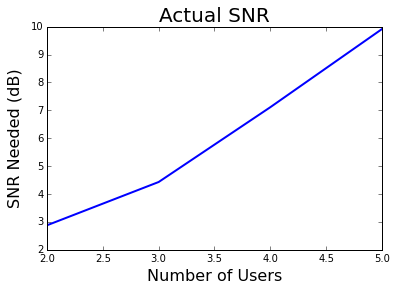

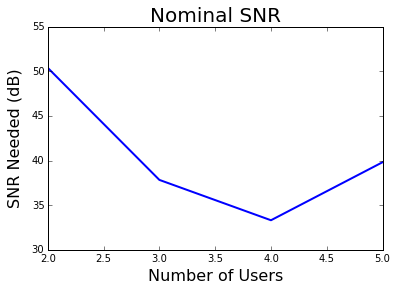

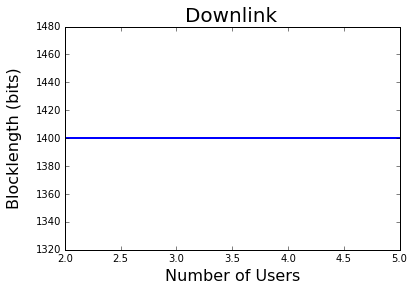

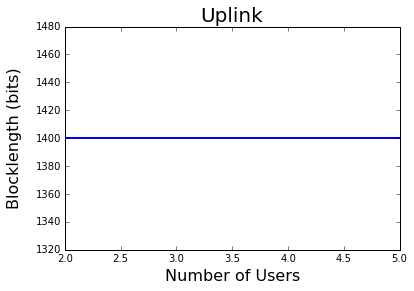

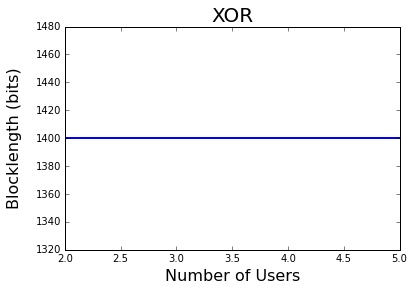

In [14]:
plot(range(2, 6), not_opt_data[1:5, 0], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Actual SNR', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 1], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 2], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Downlink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 3], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Uplink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 4], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('XOR', fontsize=20)

In [50]:
# 1,400 * 3 phases = 4,200
def medium_optimized(N, SNR_range, filepath_down, filepath_up):
    #downtarget, uptarget = logsearch(10**(-8), 10**(-10), 20)
    protocol_target = 10**(-9)
#     downtarget, uptarget = 1 * 10**(-9), 1 * 10**(-9)
    
    downbit, upbit = 1400, 1400
    downTable = hs_rs_table(SNR_range, N*160/downbit, int(downbit/21))
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    upTable = hs_rs_table(SNR_range, N*160/upbit, int(upbit/21/N))
    upfunc = interp1d(upTable[0], upTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    xorbit = 1400
#     blocklength = int(xorbit / 21)
#     rate = N * 160 / xorbit * 7 / 4 if xorbit else float("inf")
#     k = (1-rate)*blocklength
    xor_table = hs_rs_table(SNR_range, N*160/xorbit, int(xorbit/21))
    xor_func = interp1d(xor_table[0], xor_table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    for actual_SNR in SNR_range:
#         if downfunc(actual_SNR) > downtarget: continue
#         if upfunc(actual_SNR) > uptarget: continue
        # Replace magic number below
#         if rate > 1: continue
#         pbitdrop = Q(np.sqrt(2*10**(actual_SNR/10)))
#         hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
#         hcf = 1 - (1-hcerr)**3
#         reeddrop = sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)])
        reeddrop = xor_func(actual_SNR)
        for nom_SNR in arange(actual_SNR, actual_SNR+90, 0.1):
            xor_opt = xor_analysis_opt(N, reeddrop, nom_SNR, actual_SNR, downfunc(actual_SNR), upfunc(actual_SNR))
            if 1-xor_opt <= protocol_target:
                return (actual_SNR, nom_SNR, downbit, upbit, xorbit)

In [48]:
%%time
SNR_range = arange(2, 11, 0.1)
medium_data = zeros((5, 5))
for n in range(1, 6):
    z = medium_optimized(n, SNR_range, filepath_down, filepath_up)
    medium_data[n-1] = z

# print data

CPU times: user 40.2 s, sys: 269 ms, total: 40.5 s
Wall time: 41.6 s


In [39]:
print medium_data

[[    nan     nan     nan     nan     nan]
 [    2.2    60.5  1400.   1400.   1400. ]
 [    2.9    41.8  1400.   1400.   1400. ]
 [    4.5    35.   1400.   1400.   1400. ]
 [    8.8    62.8  1400.   1400.   1400. ]]


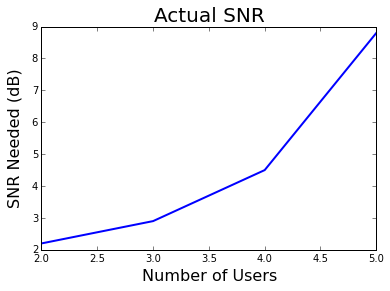

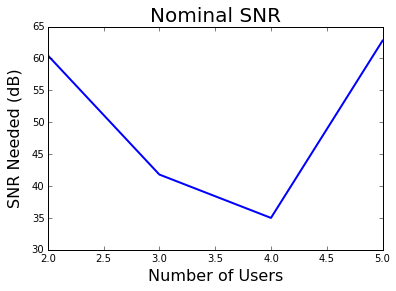

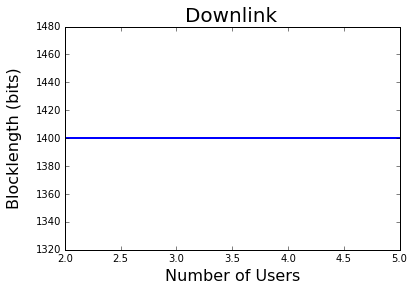

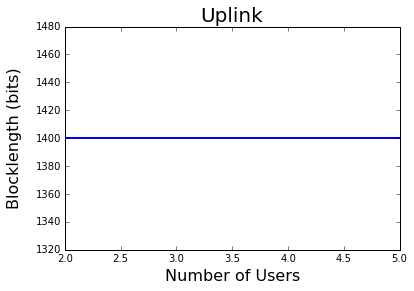

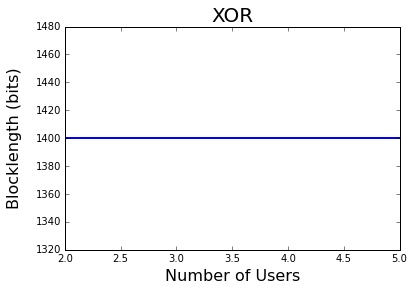

In [40]:
plot(range(2, 6), medium_data[1:5, 0], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Actual SNR', fontsize=20)

figure()
plot(range(2, 6), medium_data[1:5, 1], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR', fontsize=20)

figure()
plot(range(2, 6), medium_data[1:5, 2], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Downlink', fontsize=20)

figure()
plot(range(2, 6), medium_data[1:5, 3], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Uplink', fontsize=20)

figure()
plot(range(2, 6), medium_data[1:5, 4], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('XOR', fontsize=20)

## Penalty from not optimizing

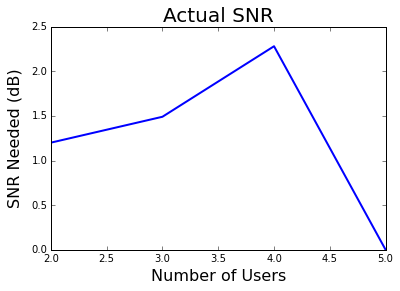

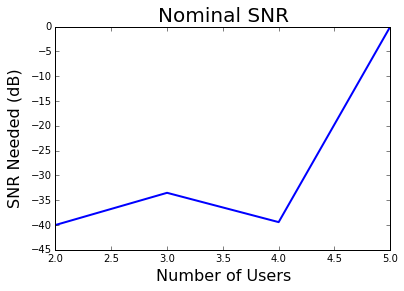

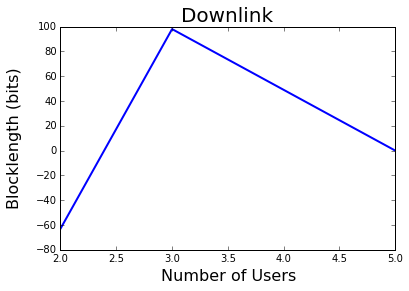

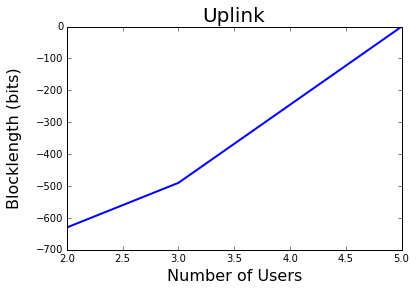

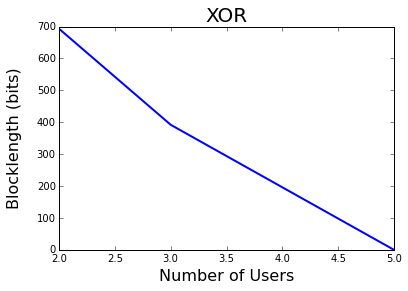

In [14]:
plot(range(2, 6), not_opt_data[1:5, 0]-data[1:5, 0], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Actual SNR', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 1]-data[1:5, 1], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 2]-data[1:5, 2], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Downlink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 3]-data[1:5, 3], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Uplink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 4]-data[1:5, 4], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('XOR', fontsize=20)

In [43]:
logspace(-10, -8, num=20)

array([  1.00000000e-10,   1.27427499e-10,   1.62377674e-10,
         2.06913808e-10,   2.63665090e-10,   3.35981829e-10,
         4.28133240e-10,   5.45559478e-10,   6.95192796e-10,
         8.85866790e-10,   1.12883789e-09,   1.43844989e-09,
         1.83298071e-09,   2.33572147e-09,   2.97635144e-09,
         3.79269019e-09,   4.83293024e-09,   6.15848211e-09,
         7.84759970e-09,   1.00000000e-08])

In [55]:
comparing = []

In [63]:
comparing.append(not_opt_data[1:5, 1]-data[1:5, 1])

In [64]:
print comparing

[array([-41.36, -38.77, -44.49,   0.  ]), array([-40.  , -33.51, -39.42,   0.  ]), array([-38.45, -28.26, -13.46,    nan])]


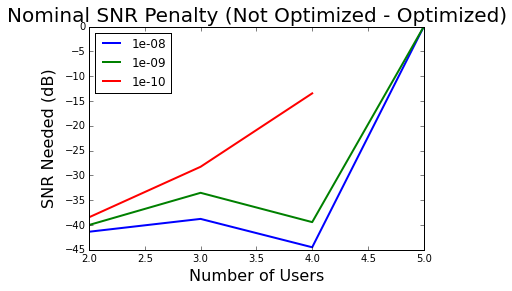

In [69]:
# Legend represents different downtargets
# Downtarget = Target probability of failure for downlink
# Downtarget == Uptarget for our simplified model
plot(range(2, 6), comparing[0], lw=2.0, label=10**(-8))
plot(range(2, 6), comparing[1], lw=2.0, label=10**(-9))
plot(range(2, 6), comparing[2], lw=2.0, label=10**(-10))
legend(loc=0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR Penalty (Not Optimized - Optimized)', fontsize=20)

# Not Optimized Minus Medium Optimized

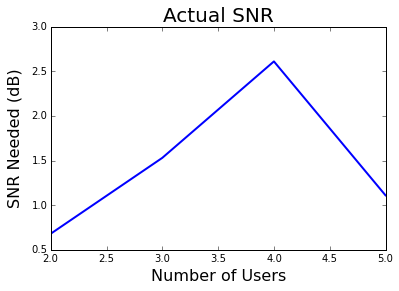

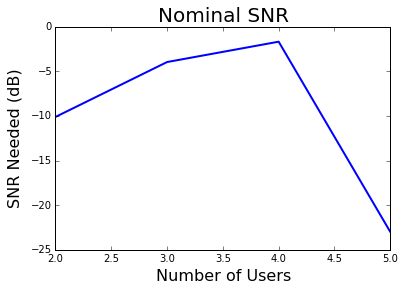

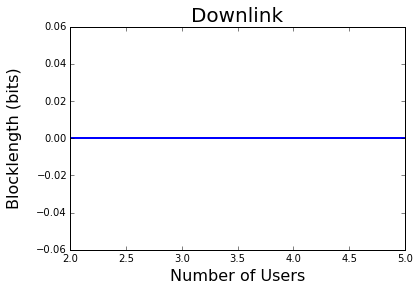

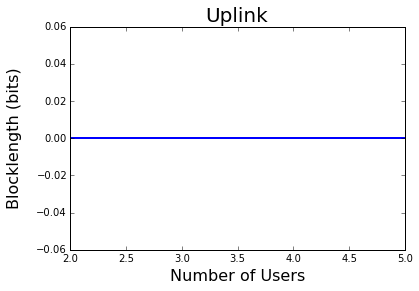

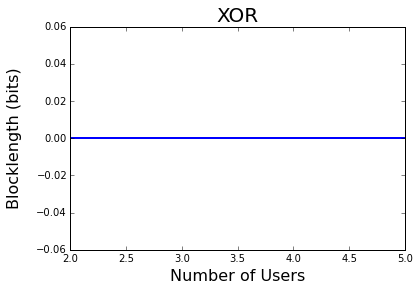

In [41]:
plot(range(2, 6), not_opt_data[1:5, 0]-medium_data[1:5, 0], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Actual SNR', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 1]-medium_data[1:5, 1], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 2]-medium_data[1:5, 2], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Downlink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 3]-medium_data[1:5, 3], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Uplink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 4]-medium_data[1:5, 4], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('XOR', fontsize=20)

### Testing the gap between Actual SNR and Nominal SNR

In [102]:
# 1,400 * 3 phases = 4,200
#downtarget, uptarget = logsearch(10**(-8), 10**(-10), 20)
def optimization(N, SNR_range, filepath_down, filepath_up, downtarget=10**(-9), uptarget=10**(-9)):
    protocol_target = 10**(-9)
    downFile = filepath_down + str(N) + '.in'
    downNode = load_table(downFile)
    upFile = filepath_up + str(N) + '.in'
    upNode = load_table(upFile)
    for actual_SNR in SNR_range:
        downbit, upbit = float("inf"), float("inf")
        for bit in downNode.bitrange:
            bittable = downNode.tables[bit]
            func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
            if func(actual_SNR) <= downtarget:
                downbit = bit
                break
        for bit in upNode.bitrange:
            bittable = upNode.tables[bit]
            func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
            if func(actual_SNR) <= uptarget:
                upbit = bit
                break
        # Replace magic number below
        xorbit = max(0, 4200 - downbit - upbit)
        # We calculate reeddrop each time because the rate changes every time (new table)
        blocklength = int(xorbit / 21)
        rate = N * 160 / xorbit * 7 / 4 if xorbit else float("inf")
        if rate > 1: continue
        k = (1-rate)*blocklength
        pbitdrop = Q(np.sqrt(2*10**(actual_SNR/10)))
        hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
        hcf = 1 - (1-hcerr)**3
        reeddrop = sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)])
        for nom_SNR in arange(actual_SNR, actual_SNR+90, 0.1):
            xor_opt = xor_analysis_opt(N, reeddrop, nom_SNR, actual_SNR, downtarget, uptarget) # success prob
            if 1-xor_opt <= protocol_target:
                print actual_SNR, 1-xor_opt, reeddrop, nom_SNR, downtarget, uptarget
#                 print actual_SNR, nom_SNR, downbit, upbit, xorbit
                z.append((actual_SNR, nom_SNR-actual_SNR, reeddrop))
                break
#                 return (actual_SNR, nom_SNR, downbit, upbit, xorbit)

In [103]:
%%time
n = 2
SNR_range = arange(2, 3, 0.1)
z = []
optimization(n, SNR_range, filepath_down, filepath_up, 10**(-9), 10**(-9))

2.2 9.83805925614e-10 0.0718818669385 88.2 1e-09 1e-09
2.3 9.84377912516e-10 0.00243945015786 72.3 1e-09 1e-09
2.4 9.89814452623e-10 3.24931214455e-05 54.2 1e-09 1e-09
2.5 9.62627200174e-10 1.94924792724e-07 50.0 1e-09 1e-09
2.6 9.94430982004e-10 1.31706481604e-08 50.0 1e-09 1e-09
2.7 9.93474080779e-10 2.4141991231e-11 50.1 1e-09 1e-09
2.8 9.93472304422e-10 2.16709298695e-14 50.2 1e-09 1e-09
2.9 9.93472304422e-10 3.10002830183e-15 50.3 1e-09 1e-09
CPU times: user 406 ms, sys: 11.5 ms, total: 417 ms
Wall time: 468 ms


[[  2.20000000e+00   8.60000000e+01   7.18818669e-02]
 [  2.30000000e+00   7.00000000e+01   2.43945016e-03]
 [  2.40000000e+00   5.18000000e+01   3.24931214e-05]
 [  2.50000000e+00   4.75000000e+01   1.94924793e-07]
 [  2.60000000e+00   4.74000000e+01   1.31706482e-08]
 [  2.70000000e+00   4.74000000e+01   2.41419912e-11]
 [  2.80000000e+00   4.74000000e+01   2.16709299e-14]
 [  2.90000000e+00   4.74000000e+01   3.10002830e-15]]


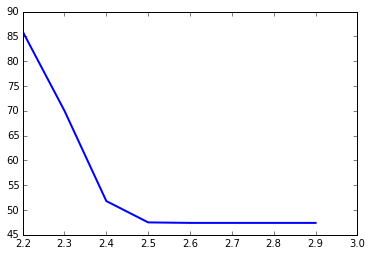

In [104]:
# x, y = zip(*z)
z = np.array(z)
plot(z[:,0], z[:,1], lw=2.0)
print z

## Looking at Actual SNR Gains

In [49]:
print data
print medium_data
print not_opt_data

[[     nan      nan      nan      nan      nan]
 [    2.18    88.48  1421.    2030.     749.  ]
 [    3.55    71.95  1302.    1890.    1008.  ]
 [    5.65    73.65  1351.    1645.    1204.  ]
 [   10.79    32.59  1400.    1400.    1400.  ]]
[[    nan     nan     nan     nan     nan]
 [    2.2    60.5  1400.   1400.   1400. ]
 [    2.9    41.8  1400.   1400.   1400. ]
 [    4.5    35.   1400.   1400.   1400. ]
 [    8.8    62.8  1400.   1400.   1400. ]]
[[     nan      nan      nan      nan      nan]
 [    2.88    50.38  1400.    1400.    1400.  ]
 [    4.43    37.83  1400.    1400.    1400.  ]
 [    7.11    33.31  1400.    1400.    1400.  ]
 [    9.91    39.81  1400.    1400.    1400.  ]]


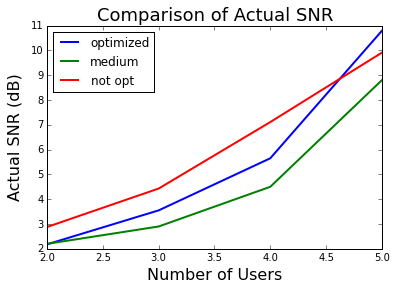

In [55]:
x = [2, 3, 4, 5]
plot(x, data[1:, 0], lw=2.0, label='optimized')
plot(x, medium_data[1:, 0], lw=2.0, label='medium')
plot(x, not_opt_data[1:, 0], lw=2.0, label='not opt')
legend(loc=0)
title('Comparison of Actual SNR', fontsize=18)
xlabel('Number of Users', fontsize=16)
ylabel('Actual SNR (dB)', fontsize=16, labelpad=10)

# print data[1:, 0]

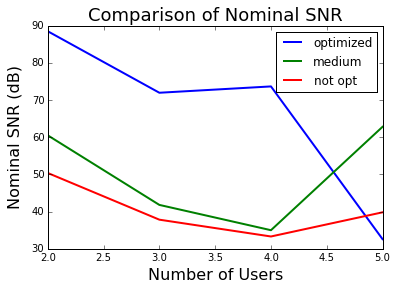

In [56]:
x = [2, 3, 4, 5]
plot(x, data[1:, 1], lw=2.0, label='optimized')
plot(x, medium_data[1:, 1], lw=2.0, label='medium')
plot(x, not_opt_data[1:, 1], lw=2.0, label='not opt')
legend(loc=0)
title('Comparison of Nominal SNR', fontsize=18)
xlabel('Number of Users', fontsize=16)
ylabel('Nominal SNR (dB)', fontsize=16, labelpad=10)

# print data[1:, 0]

In [109]:
# Final

# p_add_1 = 0.1 * 10**(-9)
# p_add_2 = 0.1 * 10**(-9)
# p_add_3 = 0.1 * 10**(-9)

# SNR_down = downtable[0][np.where(np.array(downtable[1])<=p_add_1)[0][0]]
# SNR_up = uptable[0][np.where(np.array(uptable[1])<=p_add_2)[0][0]]
# xorfunc = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

def xor_analysis_opt(N, p_add_3, nom_SNR, actual_SNR, p_add_1=10**(-9), p_add_2=10**(-9)):
    hcrit_1 = hcrit_2 = 10**((actual_SNR - nom_SNR)/10) # linear fade
    p_fade_1 = 1 - np.exp(-hcrit_1)
#     hcrit_2 = 10**((actual_SNR - nom_SNR)/10) # linear fade
    p_fade_2 = 1 - np.exp(-hcrit_2)
#     p_fade_1 = p_fade_2 = 1 - np.exp(-1)
    p_link_1 = p_fade_1 + (1 - p_fade_1) * p_add_1
    p_link_2 = p_fade_2 + (1 - p_fade_2) * p_add_2
    q = p_add_1 / p_link_1
#     p_add_3 = xorfunc(SNR)
    
    result = 0
    for ad in range(1, N+1):
        p_ad = nCr(N, ad) * (1 - p_link_1)**ad * p_link_1**(N-ad)
        adn_result = 0
        for adu in range(1, ad+1):
            p_adu = nCr(ad, adu) * (1 - p_add_2)**adu * p_add_2**(ad-adu)
            p_adn_success = (1 - p_add_3)**(ad - adu)
            adn_result += p_adu * p_adn_success
            
        b_result = 0
        for b in range(0, N-ad+1):
            bu_result = 0
            for bu in range(0, b+1):
                p_bu = nCr(b, bu) * (1 - p_add_2)**bu * p_add_2**(b-bu)
                p_bu_success = (1 - p_add_3)**bu
                p_rest_success = ((1 - p_link_2**ad) * (1 - p_add_3)**2)**(N-ad-bu)
                bu_result += p_bu * p_bu_success * p_rest_success
                
                
            p_b = nCr(N-ad, b) * q**b * (1-q)**(N-ad-b)
            b_result += p_b*bu_result
            
        result += p_ad * adn_result * b_result
#         print 'P(success)', result, 'P(b)', b_result, 'P(adn)', adn_result 
#     print p_add_3, result, b_result
    return result

In [118]:
test = xor_analysis_opt(2, 7.18818669e-02, 300, 2.2, p_add_1=10**(-9), p_add_2=10**(-9))
print 1-test

PFade 1 0.0
P q 1.0
2.87527335274e-10
